# Exploration05 - 나의 첫 번째 캐글 경진대회, 무작정 따라해보기

[캐글 코리아와 함께하는 2nd ML 대회 - House Price Prediction](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr
)에 참가해보자.

---

### 루브릭 평가 기준

1. 캐글 데이터 분석 과정의 진행 - 데이터 전처리, 모델 학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었나
2. 전처리, 학습 과정 및 결과에 대한 설명과 시각화 - 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 과정이 체계적으로 기술되었나
3. 회귀모델 예측 정확도 - 다양한 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었나

---

### 목차

0) 필요 모듈 import


1) Baseline 제출 결과


2) 데이터
  - 데이터 로드 및 확인
  - 간단한 전처리
   
    
3) 학습
  - 학습 및 결과 확인
  - Grid Search
  - Average Blending


4) 제출 결과


5) 회고


6) 참고자료

## 0. 필요 모듈 import

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import KFold, cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 학습 모델
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# 그리드 탐색을 이용하기 위해
from sklearn.model_selection import GridSearchCV

## 1. Baseline 제출 결과

대회에서 제공한 baseline은 결측치 확인, 데이터 전처리, 교차 검증 등의 내용을 포함하고 있다.  
이를 이용하여 학습을 진행한 결과를 제출해보았다.  
캐글 대회에 대한 경험이 없었기 때문에 전반적인 과정을 알 수 있었다.  

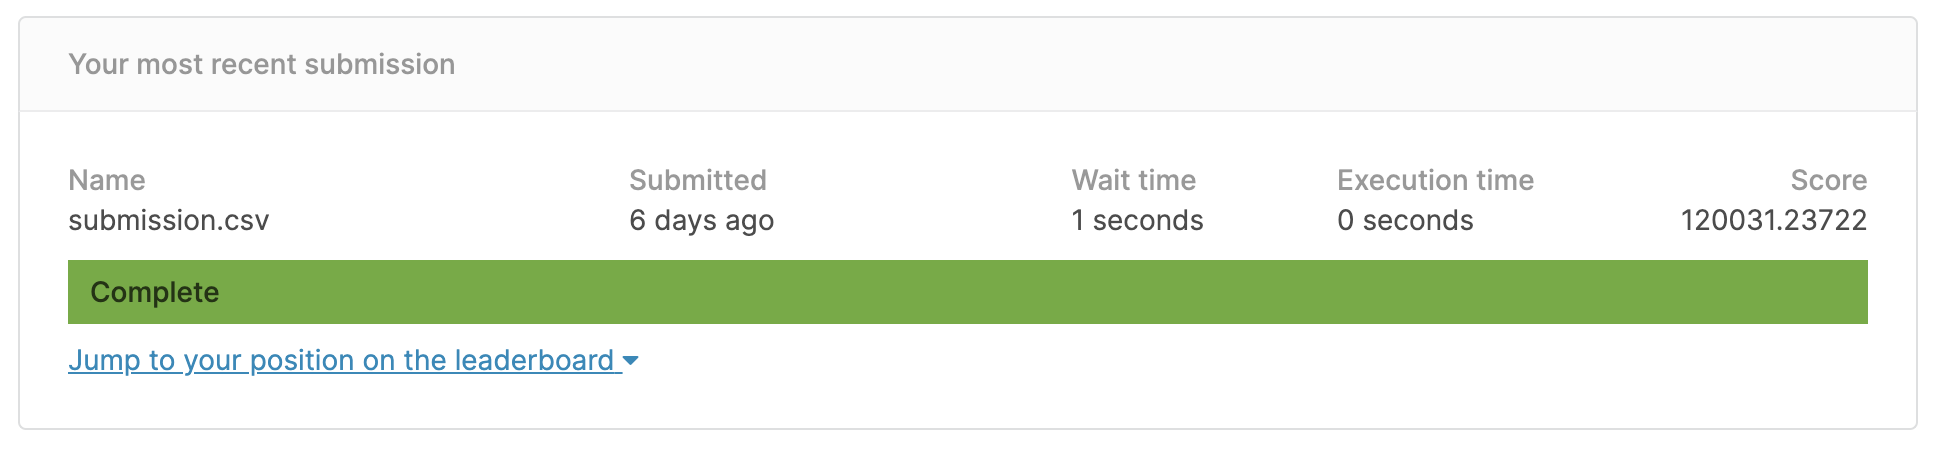

#### 12만이 넘는 점수를 11만 아래로 낮춰보자 ୧(﹒︠ᴗ﹒︡)୨  


---

## 2. 데이터

baseline을 통해 제출 방법을 알게 되었으니 이제 직접 데이터를 전처리하여 학습에 사용하겠다.

### - 데이터 로드 및 확인

In [2]:
data_dir = os.getcwd() + '/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') # 이 데이터의 가격을 맞춰 제출하면 됨

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

#### - 각 변수들이 나타내는 의미는 아래와 같다.

1. ID : 집을 구분하는 번호  
2. date : 집을 구매한 날짜  
___3. price : 타겟 변수인 집의 가격___  
4. bedrooms : 침실의 수  
5. bathrooms : 침실당 화장실 개수   
6. sqft_living : 주거 공간의 평방 피트  
7. sqft_lot : 부지의 평방 피트  
8. floors : 집의 층 수  
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)  
10. view : 집이 얼마나 좋아 보이는지의 정도  
11. condition : 집의 전반적인 상태  
12. grade : King County grading 시스템 기준으로 매긴 집의 등급  
13. sqft_above : 지하실을 제외한 평방 피트  
14. sqft_basement : 지하실의 평방 피트  
15. yr_built : 집을 지은 년도  
16. yr_renovated : 집을 재건축한 년도  
17. zipcode : 우편번호  
18. lat : 위도  
19. long : 경도  
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)  
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)  


#### * test data에 대해 price 컬럼을 예측해야 한다.

### - 간단한 전처리

In [5]:
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


test data는 우리가 맞춰야 할 집의 가격에 대한 컬럼(price)이 없기 때문에 train data와 차이를 보인다.  
train data에서 정답에 해당하는 price 컬럼은 y라는 변수에 할당한 후 삭제한다.

In [6]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


date 컬럼은 집을 구매한 날짜+T000000 형식으로 되어있는데 이를 년, 월까지만 잘라 정수형 데이터로 처리하여 예측을 위한 특성으로 사용할 수 있도록 한다.

In [7]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

id 컬럼은 분석과 무관한 데이터이므로 삭제한다.

In [8]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


test data도 train data와 동일한 처리를 해준다. 다만, price 컬럼은 없으므로 고려하지 않아도 된다.

In [9]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


---


#### 전체적인 데이터의 분포를 확인해보자.

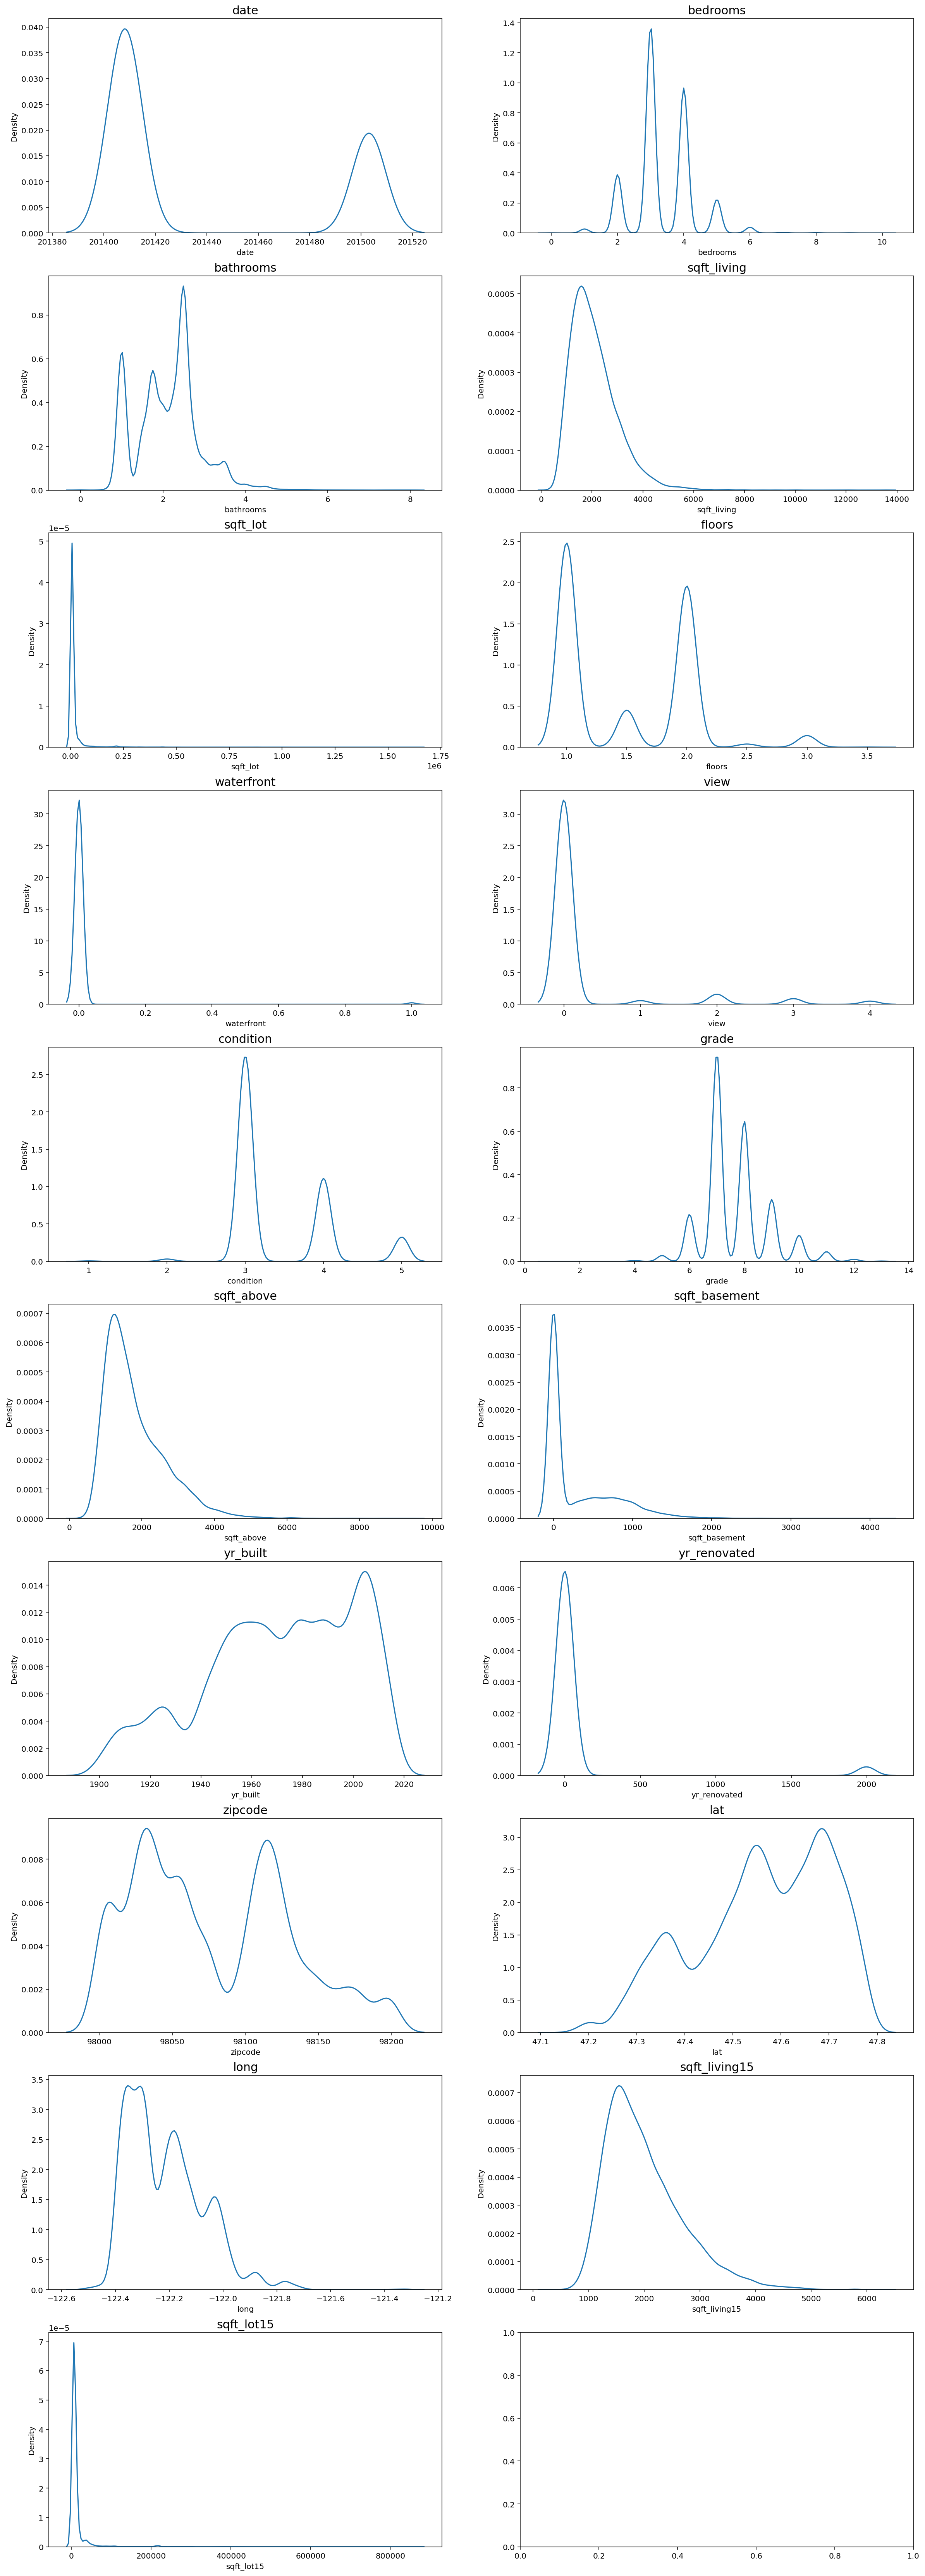

In [10]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# 변수의 분포 확인
count = 0
columns = train.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 컬럼은 왼쪽으로 분포가 몰려있다.  
로그 변환을 통해 데이터 분포를 정규분포에 가깝게 만들어보자.

In [11]:
# 치우친 데이터 로그 변환

skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

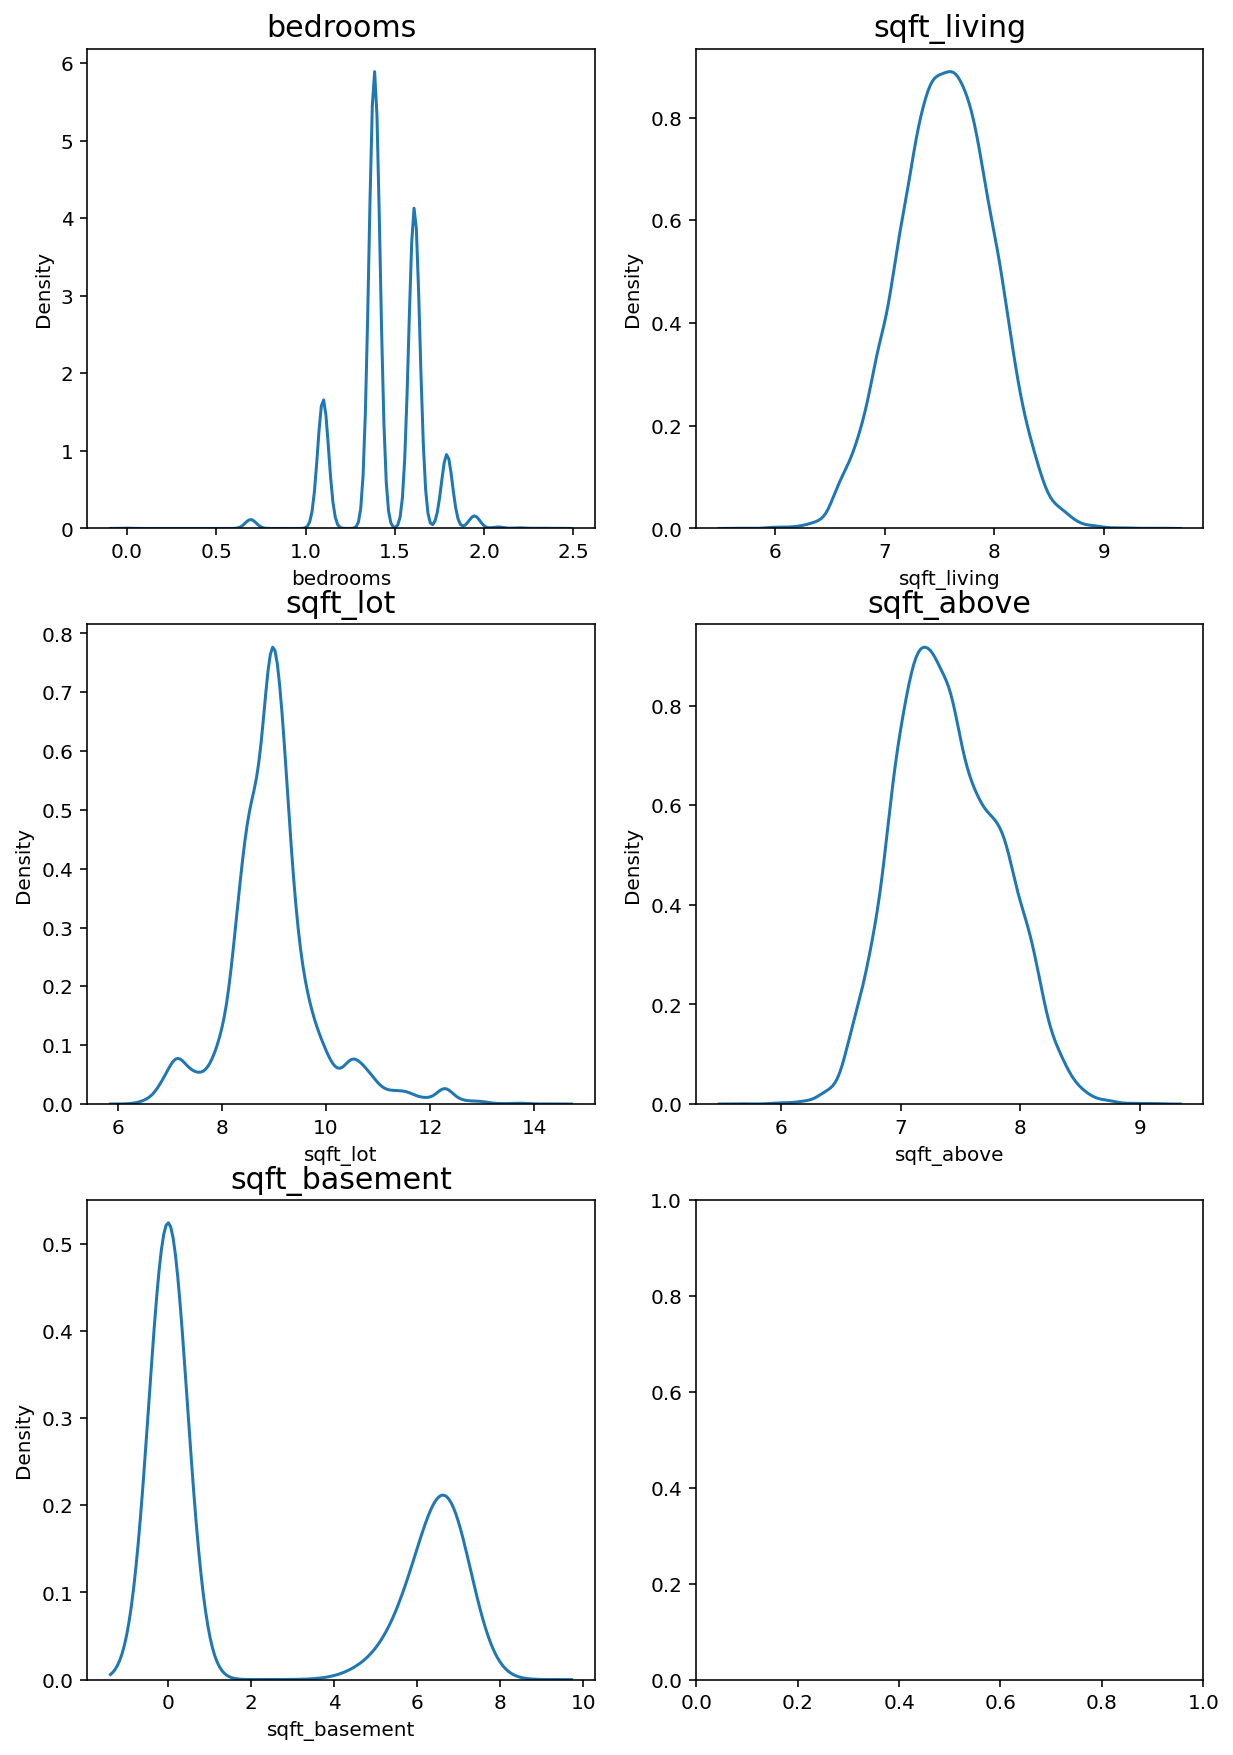

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1


test data도 train data와 동일한 처리를 해준다.

In [13]:
# 치우친 데이터 로그 변환

skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    test[c] = np.log1p(test[c].values)

#### 타겟 데이터인 y의 분포도 확인해보자.

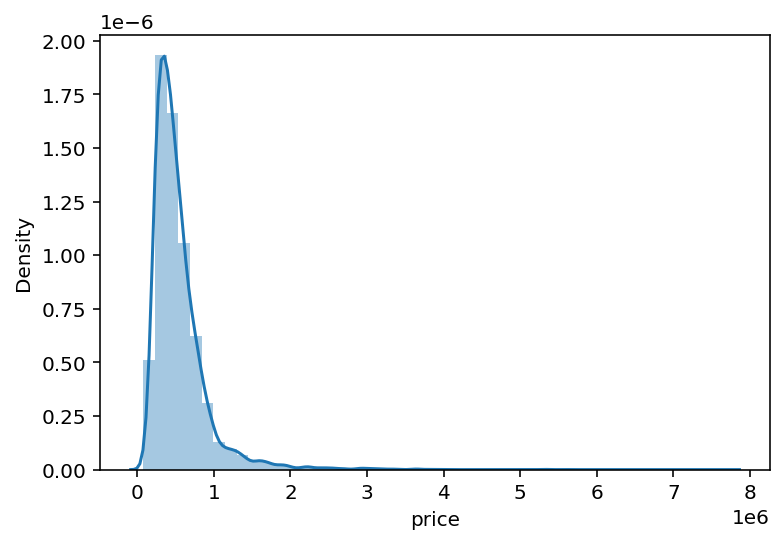

In [14]:
sns.distplot(y)
plt.show()

왼쪽으로 많이 치우쳐져 있는 모습을 보인다.  
이를 로그 변환하여 정규분포 형태로 바꾸어보자.

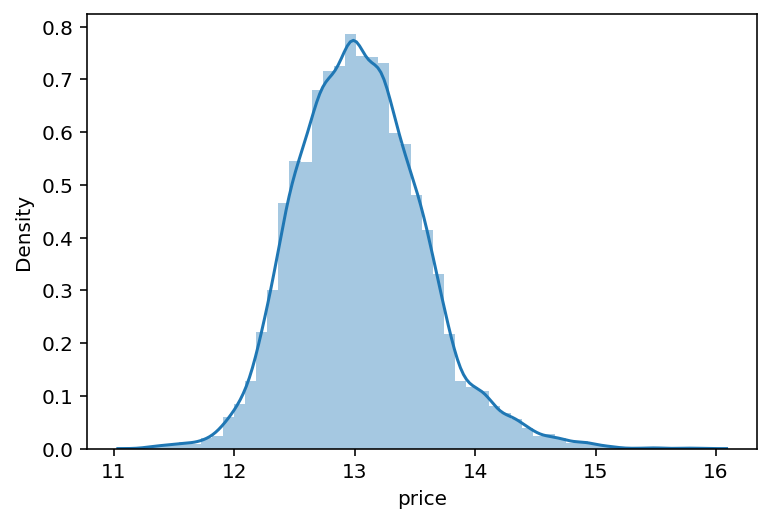

In [15]:
y = np.log1p(y)

sns.distplot(y)
plt.show()

* 예측 후에는 np.expml( )을 활용해 원래의 값으로 되돌려주어야 한다.

#### * 왜 로그 변환은 데이터의 분포를 고르게 펼쳐줄까?

로그 함수의 형태를 보면 그 이유를 알 수 있다.

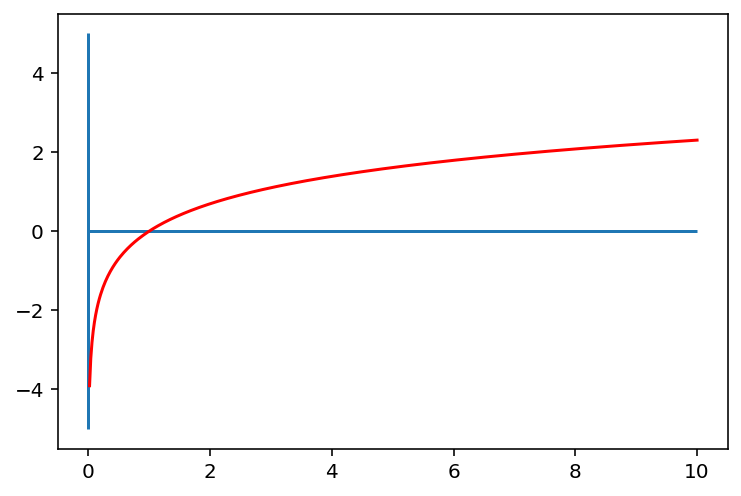

In [16]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

로그 함수는 0<x<1 범위에서는 기울기가 매우 가파르다. x의 구간이 (0,1)일때 y는 (-∞, 0)의 값을 가진다.  
따라서 0에 가깝게 모여있는 값들을 입력하면 y 값들은 매우 큰 범위로 벌어지게 된다.  


반면, x값이 커짐에 따라 로그 함수의 기울기는 급격히 작아진다.  
큰 x값들에 대해서는 y값이 크게 차이나지 않게 되고, 넓은 범위를 가지는 x값을 비교적 작은 y값 구간 내에 모이게 한다.



---

## 3. 학습

### - 학습 및 결과 확인

4가지 모델에 대해 학습을 하고 대회의 평가 척도인 RMSE를 계산해보자.

In [17]:
# 학습 모델

random_state=22

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [18]:
# RMSE를 계산하는 함수

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [19]:
# 4가지 모델에 대해 학습을 진행하고 각 RMSE를 구하는 함수

def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
RandomForestRegressor,130852.365816
GradientBoostingRegressor,128007.037639
LGBMRegressor,117403.595273
XGBRegressor,110690.395609


### - Grid search

11만점에 가까운 XGB Regressor는 그대로 사용하고, LGBM Regressor에 대한 그리드 탐색을 진행해보겠다.

In [20]:
# 그리드 탐색을 하여 RMSE를 출력하는 함수

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

#### LGBM Regressor에 대한 Grid Search 진행

In [21]:
lgbm_param_grid = {
    'n_estimators': [400, 800, 1200],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.03, 0.05]
}

In [22]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, lgbm_param_grid)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
14,0.03,10,1200,-0.025861,0.160813
17,0.03,15,1200,-0.025887,0.160894
22,0.05,10,800,-0.025904,0.160947
13,0.03,10,800,-0.025928,0.161022
25,0.05,15,800,-0.025941,0.161061
16,0.03,15,800,-0.025951,0.161093
21,0.05,10,400,-0.026036,0.161356
23,0.05,10,1200,-0.026058,0.161426
24,0.05,15,400,-0.026087,0.161515
26,0.05,15,1200,-0.026097,0.161547


learning_rate=0.03, max_depth=10, n_estimators=1200 일 때 우수한 성능을 보인다.  
이 결과를 바탕으로 LGBM Regressor의 학습을 진행해보자.

In [23]:
model = LGBMRegressor(learning_rate=0.03, max_depth=10, n_estimators=1200, random_state=random_state)

model.fit(train, y)

LGBMRegressor(learning_rate=0.03, max_depth=10, n_estimators=1200,
              random_state=22)

In [24]:
# 예측 및 값 변환

prediction_lgbm = model.predict(test)
prediction_lgbm = np.expm1(prediction_lgbm) # 데이터 전처리 과정에서 로그 변환 해주었던 것을 다시 되돌려준다.
prediction_lgbm

array([ 504640.35698364,  475531.00024336, 1327447.99794445, ...,
        481326.99875861,  338148.94578206,  440286.19062053])

#### XGB Regressor에 대한 학습 진행

In [25]:
model = XGBRegressor(random_state=random_state)

model.fit(train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=22,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
# 예측 및 값 변환

prediction_xgb = model.predict(test)
prediction_xgb = np.expm1(prediction_xgb) # 데이터 전처리 과정에서 로그 변환 해주었던 것을 다시 되돌려준다.
prediction_xgb

array([ 493703.1 ,  464143.72, 1232520.2 , ...,  485601.8 ,  334678.34,
        470608.88], dtype=float32)

### - Average Bleding

두 모델의 예측 결과를 평균내어 제출 파일을 만들어보자.

In [27]:
prediction_ensemble = np.vstack([prediction_lgbm, prediction_xgb]).mean(0)

In [28]:
submission_path = join(data_dir, 'sample_submission.csv')

sub = pd.read_csv(submission_path)
sub.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [29]:
sub['price'] = prediction_ensemble
sub.head()

,id,price
0,15035,4.991717e+05
1,15036,4.698374e+05
2,15037,1.279984e+06
3,15038,2.901141e+05
4,15039,3.303634e+05


In [30]:
sub_csv_path = '{}/submission_lgbmL_xgb2.csv'.format(data_dir)
sub.to_csv(sub_csv_path, index=False)

[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=400; total time=   2.4s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=800; total time=   4.9s
[CV] END .learning_rate=0.01, max_depth=5, n_estimators=1200; total time=   6.5s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=800; total time=   6.4s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=1200; total time=   9.5s
[CV] END .learning_rate=0.01, max_depth=15, n_estimators=800; total time=   5.9s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=1200; total time=  10.0s
[CV] END ..learning_rate=0.03, max_depth=5, n_estimators=800; total time=   2.8s
[CV] END .learning_rate=0.03, max_depth=5, n_estimators=1200; total time=   4.3s
[CV] END .learning_rate=0.03, max_depth=10, n_estimators=400; total time=   2.5s
[CV] END .learning_rate=0.03, max_depth=10, n_estimators=400; total time=   2.0s
[CV] END .learning_rate=0.03, max_depth=10, n_estimators=800; total time=   4.6s
[CV] END learning_rate=0.03,

[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=400; total time=   1.9s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=800; total time=   3.3s
[CV] END .learning_rate=0.01, max_depth=5, n_estimators=1200; total time=   5.0s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=400; total time=   3.5s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=400; total time=   3.1s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=800; total time=   4.3s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=1200; total time=   8.2s
[CV] END .learning_rate=0.01, max_depth=15, n_estimators=400; total time=   2.6s
[CV] END .learning_rate=0.01, max_depth=15, n_estimators=800; total time=   4.6s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=1200; total time=   7.2s
[CV] END ..learning_rate=0.03, max_depth=5, n_estimators=400; total time=   2.5s
[CV] END ..learning_rate=0.03, max_depth=5, n_estimators=800; total time=   5.2s
[CV] END .learning_rate=0.03

---
## 4. 제출 결과

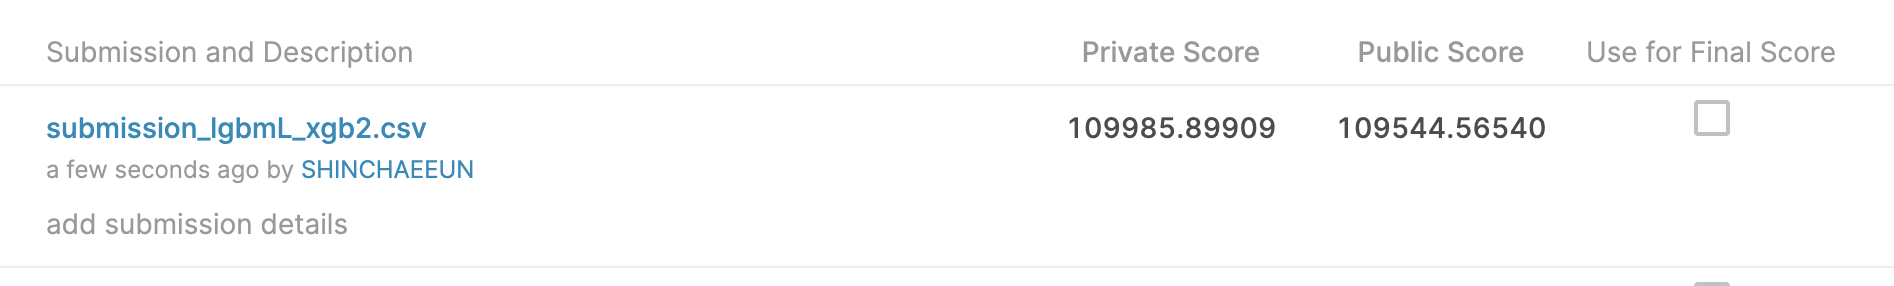

#### * Private Score가 11만점 이하이므로 루브릭 기준 달성 ヽ〳 ՞ ᗜ ՞ 〵ง

## 5. 회고

- 그리드 서치에 대한 내용을 책으로 학습했지만 어떻게 쓰는것인지 감이 잘 오지 않았었다. 이번 프로젝트를 통해 튜닝해야 할 파라미터들이 여러 개 있을 때 그리드 서치를 어떻게 사용하는 것인지 알게 된 것 같다.  
  

- 그리드 서치를 진행함에 있어 너무 많은 파라미터 값을 살펴볼 수는 없기 때문에 일정 범위 안에서 값을 조정하는 것이 필요한데, 해당 모델에 자주 쓰이는 값이 무엇인지 몰라 한참을 고민했다.
  내가 아예 탐색조차 하지 않은 파라미터 값에서 최적의 결과가 나올 수도 있는 것이기 때문에 루브릭 기준은 만족했어도 최고의 결과라는 생각은 들지 않는다.
 
 
- 튜닝을 잘못했다간 디폴트 값으로 학습한 것 보다 더 안좋은 결과를 내기도 한다. 특히 XGB Regressor 같은 경우는 아무것도 설정하지 않고 학습을 하는 것이 가장 성능이 좋았다.


- 하이퍼파라미터를 조금씩 바꾸는 것 보단 데이터 전처리를 잘 하는 것이 점수를 높이는데는 더 효과적인 것 같다.  
  처음에는 price에 대한 값만 로그 변환을 하여 이런 저런 시도를 많이 했는데, 그리드 서치에 비용이 많이 들고 그에 비해 효과는 크지 않았다.  
  이후 데이터의 다른 컬럼에도 로그 변환을 하고 학습을 진행하였는데 루브릭 기준을 달성할 수 있었다.   
  데이터를 가지고 다른 시도를 해본다면 더 좋은 성과를 낼 수 있을 것 같다.
  

- 최종 결과에는 담지 않았지만 XGB Regressor에 대해 그리드 탐색을 진행할 때, 다른 모델과는 다른 경고문이 출력된다.  
  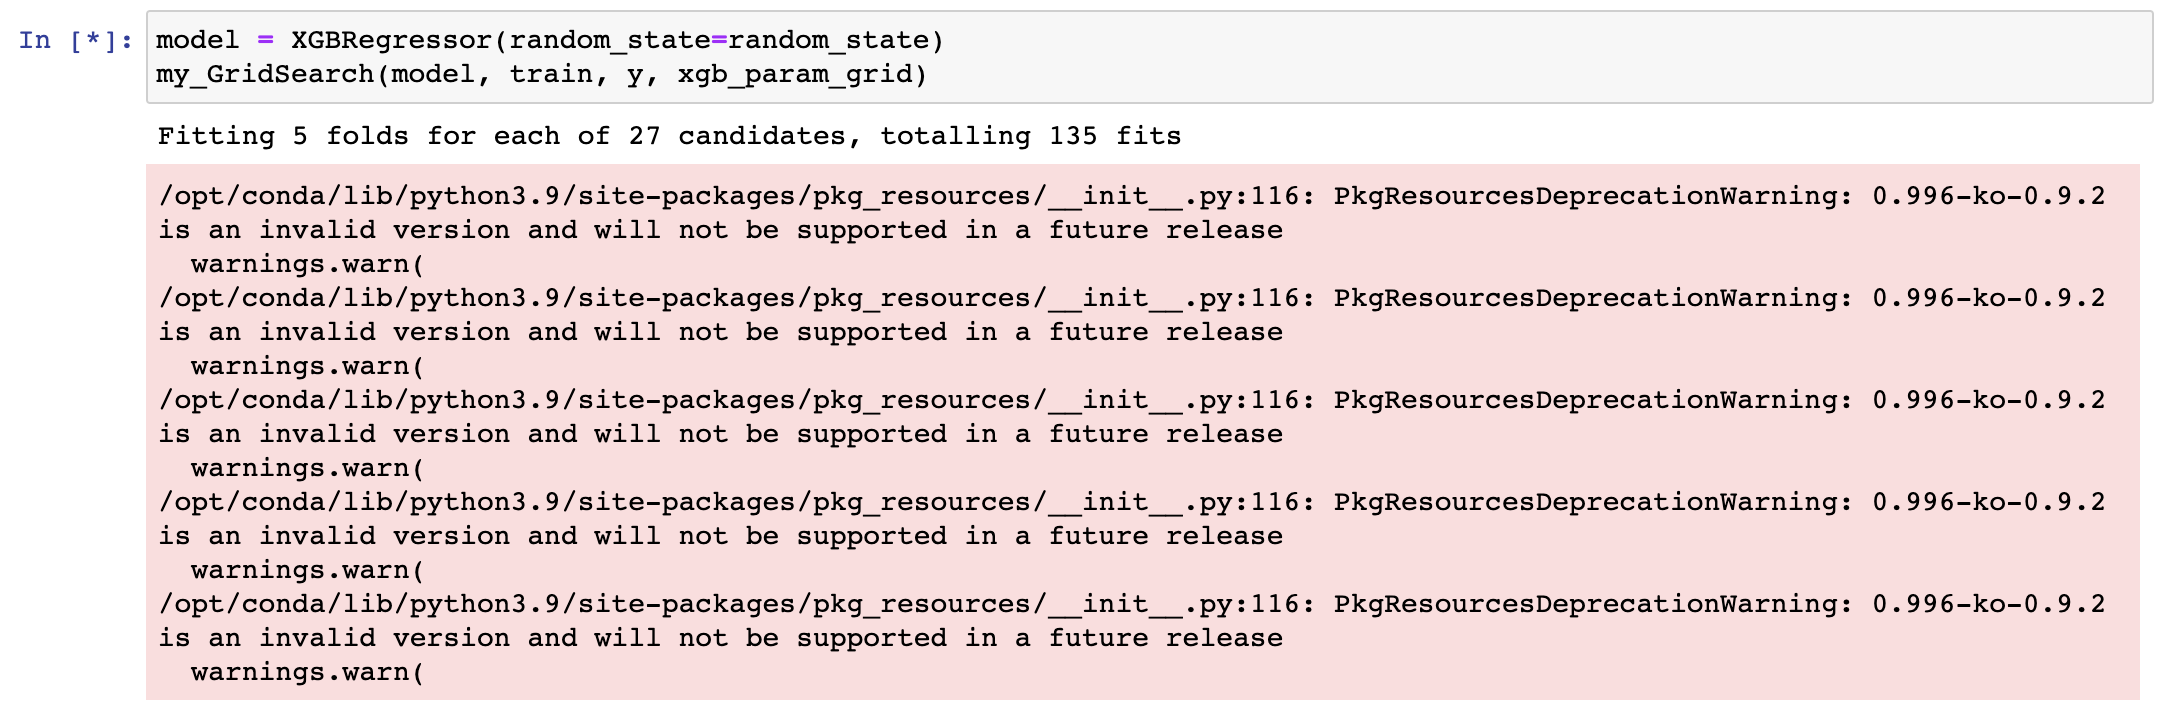
  0.996-ko-0.9.2에 대해 검색을 해보니 한글 형태소 분석기와 관련된 글이 대다수인데, 이 프로젝트와는 상관이 없는 패키지가 어떤 문제를 일으키는지는 아직 모르겠다.  
  왜 다른 모델에서는 문제가 되지 않는데 XGB Regressor에서만 문제가 될까?

## 6. 참고 자료

- 하이퍼파라미터 튜닝  
  https://psystat.tistory.com/131